In [1]:
import pandas as pd
import matminer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Introduction
For this final project, the target is to predict if the material is metal or non-metal and their band gap if it is non-metal. Random Forest Classifer and Random Forest Regression are used as the machine learning prediction. The dataset chosen from Dr.Jakoah Brogch from University of Houston. There is 135 featuers are used to do training. For reverse engineering that training data to minimize the overall number of data
points and features needed, the feature importance and PCA are used as shown in code section below. Other than that, the Kmedioid cluster method is used as an acquisition policy that increases model prediction power faster than random sampling since KMedioid's center points always represent the information rich region. Also, the result of AUC score selected from KMedioid are coompared with random selection as well.

In [2]:
#open file for classification data
file = "Classification.csv"
data = pd.read_csv(file)
df_r = pd.DataFrame(data)
#data cleaning
df_r1 = df_r.iloc[:,:-1] #drop the empty row at the last
df_r2 = df_r1.dropna()
#preprocessing for featurzing
df_r3 = df_r2.rename(columns= {'Composition':'formula'}) #rename for featurization

In [3]:
#featurize the data
from matminer.featurizers.conversions import StrToComposition
df_r4 = StrToComposition(target_col_id='Composition').featurize_dataframe(df_r3, 'formula')

StrToComposition:   0%|          | 0/4916 [00:00<?, ?it/s]

In [4]:
#create dataframe with features only (x only)
df_x = df_r4.drop(df_r4.columns[[0,1,2,-1]],axis = 1)
X = df_x.to_numpy()
X_std = StandardScaler().fit_transform(X)
y_c = df_r3['class'].copy().to_numpy()
y_r_i = df_r3['Eg'].copy().to_numpy()

#### 1. Basic data visualization on data set

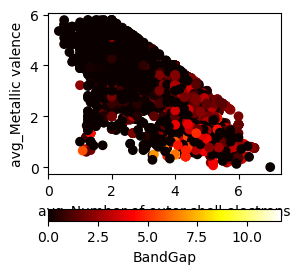

In [5]:
plt.figure(figsize = (3,3))
plt.scatter(df_r3['avg_Number of outer shell electrons'],df_r3['avg_Metallic valence'], c=y_r_i ,cmap="hot")
plt.colorbar(label="BandGap", orientation="horizontal")
plt.xlabel("avg_Number of outer shell electrons")
plt.ylabel("avg_Metallic valence")
plt.show()

#### 2. build an classifier model to predict metal or non metal by using Random Forest Classifier

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X,y_c)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [7]:
import itertools as it
#define tuning hyperparameters
tuned_hyperpar = {'max_depth': [10,20,30,40,50], 'n_estimators': [50,100,150,200,250,300]}
# enumerate all combinations of parameters
allpar = sorted(tuned_hyperpar)
combinations = list(it.product(*(tuned_hyperpar[par] for par in allpar)))

In [8]:
#The grid search will take a long time, the kernel is not dead LOL
from sklearn.ensemble import RandomForestClassifier
import numpy as np
R2_mean_list=[]
#define a scoring list
i=0
print("Grid search result")
for com in list(combinations):
    par_dict={}
    count=1
    for par_name in reversed(tuned_hyperpar.keys()):
        par_dict[par_name] = com[len(tuned_hyperpar.keys())-count]
        count+=1    
    #  use Kfold CV for every combo of parameters
    group_R2=[]
    for train_index, test_index in kf.split(X, y_c):        
        # split data into train set and test set
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_c[train_index], y_c[test_index]
        # create a model for every combo
        RFC = RandomForestClassifier(**par_dict)
        #print(par_dict)
        RFC.fit(X_train,y_c[train_index].ravel())
        #calculate R2 for every combo of parameters
        y_hat = RFC.predict(X_test)
        R2 = r2_score(y_c[test_index].ravel(), y_hat)
        group_R2.append(R2)    
    R2_mean=np.mean(group_R2)
    R2_std=np.std(group_R2)
    R2_mean_list.append(R2_mean)
    #print(f"{[f'{val:.3f}' for val in group_R2]} --> {R2_mean:0.3f} (+/-{R2_std*2:0.03f}) for {par_dict}")
    i+=1

Grid search result


Text(0, 0.5, 'n_estimators')

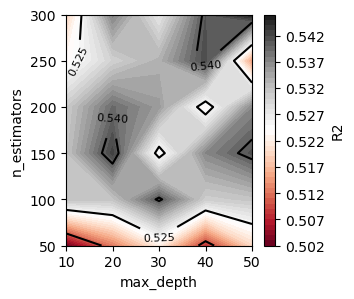

In [9]:
max_depth= [10,20,30,40,50]
n_estimators= [50,100,150,200,250,300]
Q, E = np.meshgrid(max_depth, n_estimators)
Z = np.array(R2_mean_list).reshape(6,5)
plt.figure(figsize = (3,3))
#plt.figure()
plt.contourf(Q, E, Z, 50, cmap='RdGy')
plt.colorbar(label='R2'); 
contours = plt.contour(Q, E, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [10]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth = 20,  n_estimators = 100,random_state=42)

[[336  56]
 [ 65 527]]
TN:336, FP:56, FN:65, TP:527, sum:984 

[[360  34]
 [ 78 511]]
TN:360, FP:34, FN:78, TP:511, sum:983 

[[492  51]
 [ 57 383]]
TN:492, FP:51, FN:57, TP:383, sum:983 

[[410  40]
 [ 51 482]]
TN:410, FP:40, FN:51, TP:482, sum:983 

[[595  84]
 [ 43 261]]
TN:595, FP:84, FN:43, TP:261, sum:983 



<Figure size 300x300 with 0 Axes>

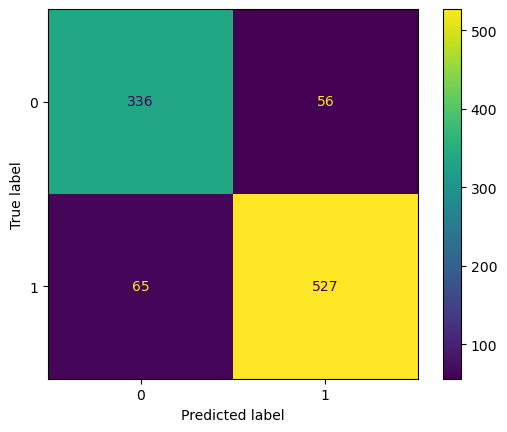

<Figure size 300x300 with 0 Axes>

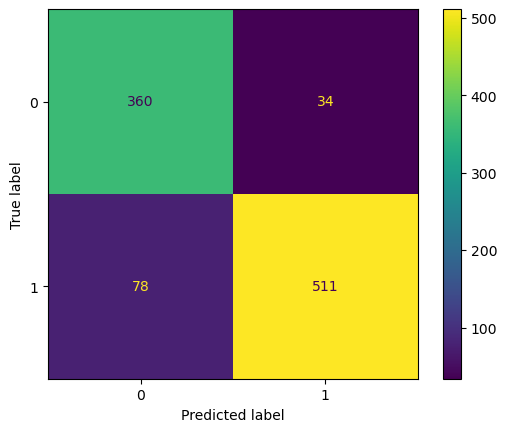

<Figure size 300x300 with 0 Axes>

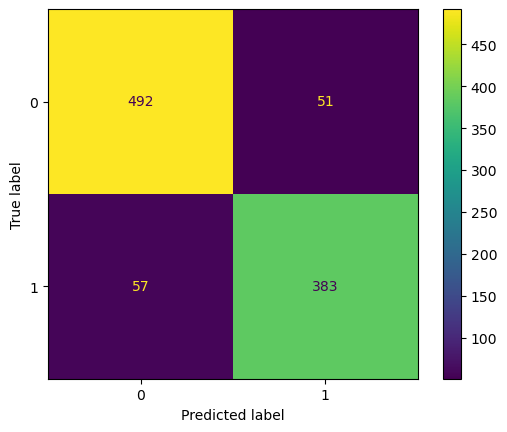

<Figure size 300x300 with 0 Axes>

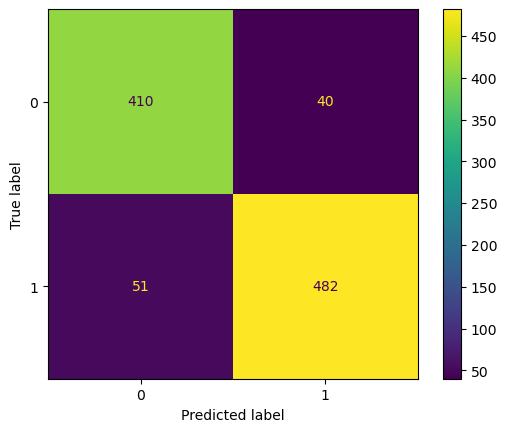

<Figure size 300x300 with 0 Axes>

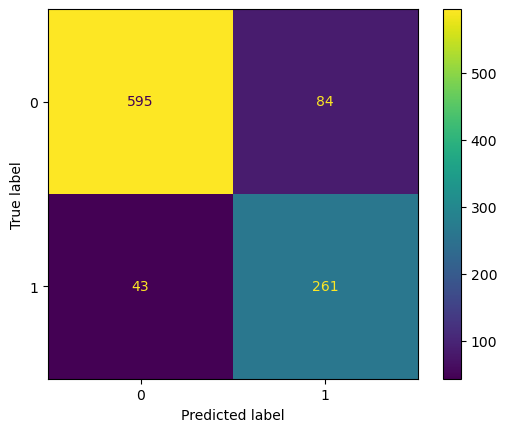

In [11]:
#Random CV to evaluate generalizability
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
for train_index, test_index in kf.split(X, y_c):        
        # split data into train set and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_c[train_index], y_c[test_index]        
        # print(len(y_test)) # - valid the kfolds was performed correctly
        # standardize the train set and test set separately
    standard_scaler = StandardScaler()
    Standardized_X_train, Standardized_X_test = standard_scaler.fit_transform(X_train),standard_scaler.transform(X_test)
        # perform the linear fitting by using the model feeded
    RFC.fit(Standardized_X_train,y_train)
    y_predict = RFC.predict(Standardized_X_test)
    CM_random = confusion_matrix(y_test, y_predict)
    print(CM_random)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print(f'TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}, sum:{tn+fp+fn+tp}','\n')
    plt.figure(figsize = (3,3))
    plot_confusion_matrix(RFC, Standardized_X_test, y_test)
    #plt.show()

In [12]:
RFC.fit(X_std,y_c.ravel())
y_hat_c = RFC.predict(X_std)
y_hat_c2 = y_hat_c.reshape(-1, 1)

[[2456    2]
 [   1 2457]]
TN:2456, FP:2, FN:1, TP:2457, sum:4916 



<Figure size 300x300 with 0 Axes>

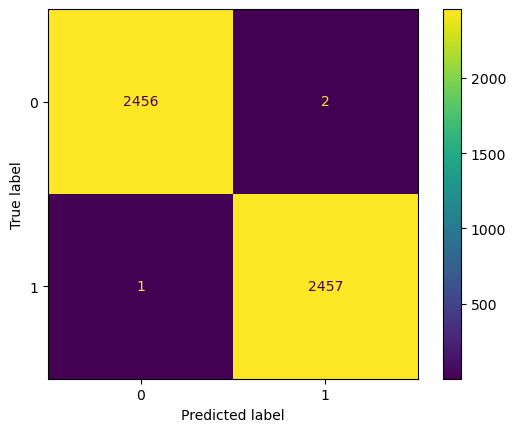

In [13]:
#Train a model on complete dataset
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plt.figure(figsize = (3,3))
CM_random = confusion_matrix(y_c, y_hat_c)
print(CM_random)
tn, fp, fn, tp = confusion_matrix(y_c, y_hat_c).ravel()
print(f'TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}, sum:{tn+fp+fn+tp}','\n')

plot_confusion_matrix(RFC, X_std, y_c)  
plt.show()

0.9993897477624085


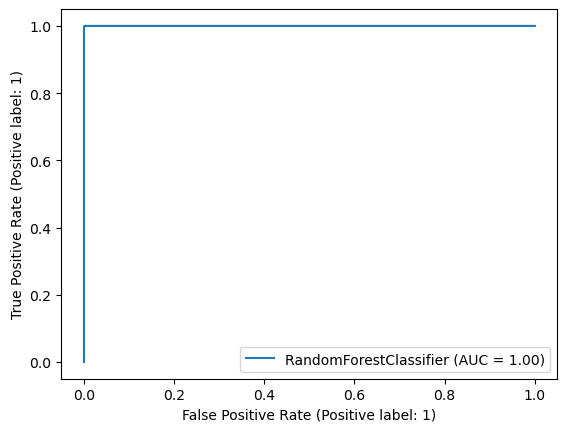

<Figure size 300x300 with 0 Axes>

In [14]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score 
AUC = roc_auc_score(y_c, y_hat_c)
print(AUC)
plot_roc_curve(RFC, X_std, y_c)
plt.figure(figsize = (3,3))
plt.show()

#### 3. build an regression model to predict the bandgap of nonmetal by using Random Forest Regressor

In [15]:
df_r5 = df_r4[df_r4['class'] == 1].copy()
#create dataframe with features only (x only)
df_x2 = df_r5.drop(df_r5.columns[[0,1,2,-1]],axis = 1)
X2 = df_x2.to_numpy()
X2_std = StandardScaler().fit_transform(X2)
y_r = df_r5['Eg'].copy().to_numpy()

In [16]:
import itertools as it

#define tuning hyperparameters
tuned_hyperpar = {'max_depth': [10,20,30,40,50,60], 'n_estimators': [50,100,150,200,250,300]}

# enumerate all combinations of parameters
allpar = sorted(tuned_hyperpar)
combinations = list(it.product(*(tuned_hyperpar[par] for par in allpar)))

In [17]:
#The grid search will take a long time
from sklearn.ensemble import RandomForestRegressor
R2_mean_list=[]
#define a scoring list
i=0
print("Grid search result")
for com in list(combinations):
    par_dict={}
    count=1
    for par_name in reversed(tuned_hyperpar.keys()):
        par_dict[par_name] = com[len(tuned_hyperpar.keys())-count]
        count+=1    
    #  use LOCO CV for every combo of parameters
    group_R2=[]
    for train_index, test_index in kf.split(X2, y_r):        
        # split data into train set and test set
        X_train, X_test = X2[train_index], X2[test_index]
        y_train, y_test = y_r[train_index], y_r[test_index]
        # create a model for every combo
        RFR = RandomForestRegressor(**par_dict)
        #print(par_dict)
        RFR.fit(X_train,y_c[train_index].ravel())
        #calculate R2 for every combo of parameters
        y_hat = RFR.predict(X_test)
        R2 = r2_score(y_r[test_index].ravel(), y_hat)
        group_R2.append(R2)    
    R2_mean=np.mean(group_R2)
    R2_std=np.std(group_R2)
    R2_mean_list.append(R2_mean)
    #print(f"{[f'{val:.3f}' for val in group_R2]} --> {R2_mean:0.3f} (+/-{R2_std*2:0.03f}) for {par_dict}")
    i+=1

Grid search result


Text(0, 0.5, 'n_estimators')

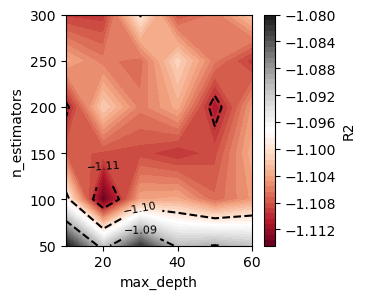

In [18]:
max_depth= [10,20,30,40,50,60]
n_estimators= [50,100,150,200,250,300]
W, R = np.meshgrid(max_depth, n_estimators)
Z = np.array(R2_mean_list).reshape(6,6)
plt.figure(figsize = (3,3))
#plt.figure()
plt.contourf(W, R, Z, 50, cmap='RdGy')
plt.colorbar(label='R2');
contours = plt.contour(W, R, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [19]:
from sklearn.ensemble import RandomForestRegressor
#Train a regression model
#According to the heatmap of r2, max deoth 30 and n_estimator 150 are used as parameter
RFR = RandomForestRegressor(max_depth = 30,  n_estimators = 150,random_state=42)
RFR.fit(X2_std,y_r.ravel())
#predict values using the model
y_hat_r = RFR.predict(X2_std)

In [20]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X2,y_r)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


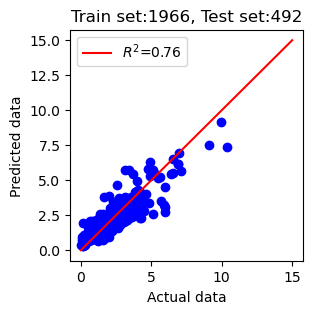

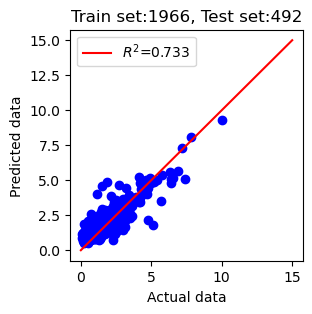

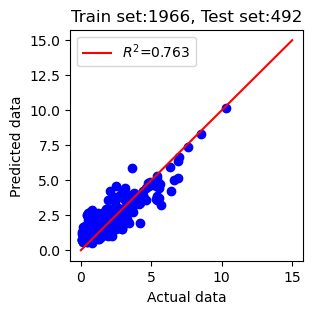

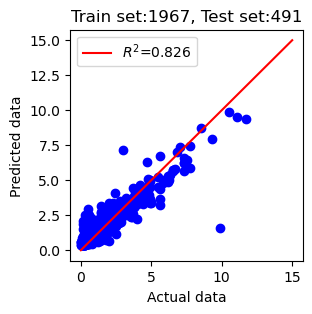

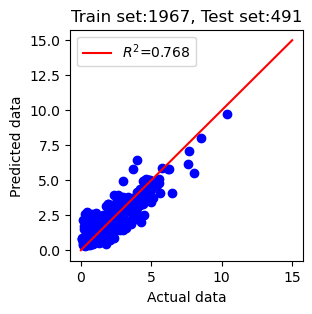

In [21]:
for train_index, test_index in kf.split(X2, y_r):        
        # split data into train set and test set
        X_train, X_test = X2[train_index], X2[test_index]
        y_train, y_test = y_r[train_index], y_r[test_index]        
        # standardize the train set and test set separately
        standard_scaler = StandardScaler()
        Standardized_X_train, Standardized_X_test = standard_scaler.fit_transform(X_train),standard_scaler.transform(X_test)
        # perform the linear fitting by using the model feeded
        RFR.fit(Standardized_X_train,y_train)
        y_predict = RFR.predict(Standardized_X_test)
        # plot the fitting 
        plt.figure(figsize = (3,3))
        plt.scatter(y_test,y_predict,color='blue',marker='o')
        plt.plot([0,15],[0,15], c='r', label='$R^{2}$='+ str(round(r2_score(y_r[test_index].ravel(), y_predict),3)) )
        plt.xlabel('Actual data')
        plt.ylabel('Predicted data')
        plt.title(f'Train set:{len(X_train)}, Test set:{len(X_test)}')
        plt.legend()

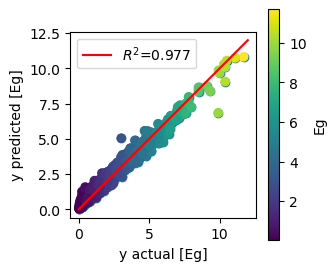

In [22]:
# Parity plot
plt.figure(figsize = (3,3))
plt.scatter(y_r, y_hat_r,c=y_r, zorder=10)
plt.xlabel('y actual [Eg]')
plt.ylabel('y predicted [Eg]')
plt.colorbar(label='Eg')
#estimate variance in prediction
std = np.std([y_hat_r for tree in RFR.estimators_], axis=0)
plt.errorbar(y_r, y_hat_r, yerr=std, fmt='o', ecolor='k', zorder=0, elinewidth=0.5)
plt.plot([0,12],[0,12], c='r', label='$R^{2}$='+ str(round(r2_score(y_r, y_hat_r),3)), zorder=20)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')

Text(0, 0.5, 'Mean decrease in impurity')

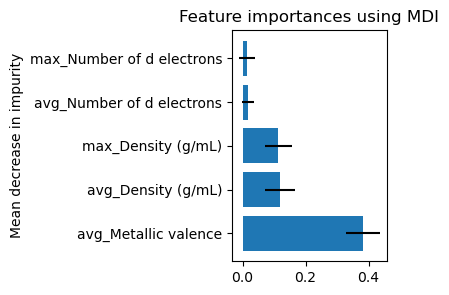

In [23]:
# get importance
importance = RFR.fit(X2_std,y_r.ravel()).feature_importances_ #using Gini importance implemented by Sklearn (Mean decrease in impurity)
std = np.std([tree.feature_importances_ for tree in RFR.estimators_], axis=0)
# plot feature importance
sort = importance.argsort()
features = pd.Series(importance)
features.sort_values(ascending=False, inplace=True)
#print(features.head(5))
features_index = features.head(5).index.tolist()
plt.figure(figsize = (2,3))
#print(sort)
plt.barh(df_x2.columns[features_index], importance[features_index], xerr=std[features_index])
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")

#### 4. Reverse Engineering on Classifier to minimize the overall number of data points and features

In [24]:
#Use feature importance ranking to drop the maximum number of features
df_fi = df_r3[['max_Density (g/mL)','avg_Density (g/mL)','avg_Metallic valence']]
X_std2 = StandardScaler().fit_transform(df_fi)

In [25]:
from sklearn.ensemble import RandomForestClassifier
#Train a classifier model
RFC = RandomForestClassifier(max_depth = 80, min_samples_leaf = 4, n_estimators = 200,random_state=42)
RFC.fit(X_std2,y_c.ravel())
#predict values using the model
y_hat_c2 = RFC.predict(X_std2)

<Figure size 300x300 with 0 Axes>

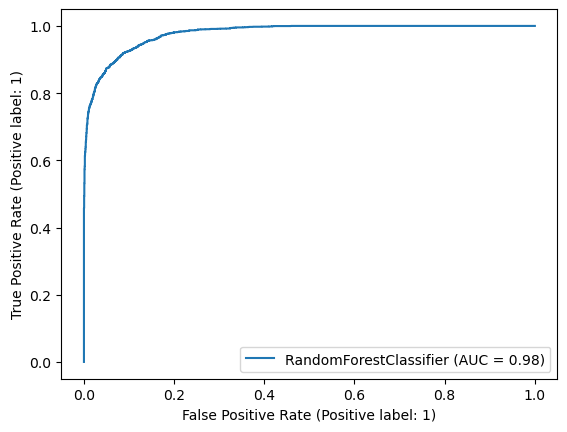

In [26]:
from sklearn.metrics import plot_roc_curve
plt.figure(figsize = (3,3))
plot_roc_curve(RFC, X_std2, y_c)

[[2171  287]
 [ 154 2304]]
TN:2171, FP:287, FN:154, TP:2304, sum:4916 



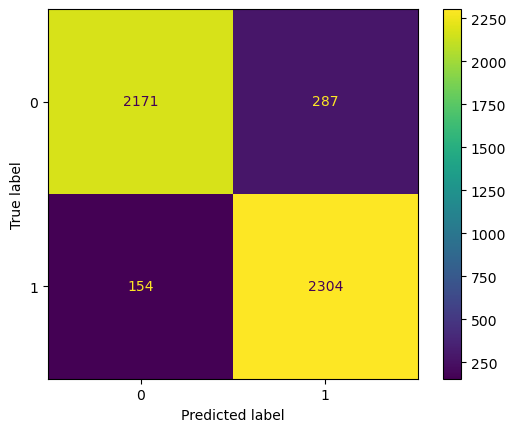

In [27]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
CM_random = confusion_matrix(y_c, y_hat_c2)
print(CM_random)
tn, fp, fn, tp = confusion_matrix(y_c, y_hat_c2).ravel()
print(f'TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}, sum:{tn+fp+fn+tp}','\n')
plot_confusion_matrix(RFC, X_std2, y_c)  
plt.show()

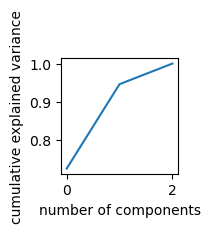

In [28]:
# Use a combination of reduced dimensional projections and distance metrics to identify information rich regions in feature space
#plotting explained variance ratio for PCA
from sklearn.decomposition import PCA
pca = PCA().fit(X_std2)
plt.figure(figsize = (1.5,1.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [29]:
pca = PCA(2)
X_X = pca.fit_transform(X_std2)
pd_XX = pd.DataFrame(X_X)
pd_XX2 = pd.concat([pd_XX,df_r4['Eg']],axis = 1)
pd_XX3 = pd.concat([pd_XX,df_r4['class']],axis = 1)
np_xx = pd_XX2.to_numpy()

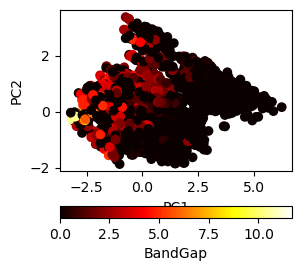

In [30]:
#plot PC1 and PC2's graph with Eg, tring to find the possible clustering
plt.figure(figsize = (3,3))
plt.scatter(x= np_xx[:,0], y=np_xx[:,1], c=np_xx[:,2], cmap="hot")  
plt.colorbar(label="BandGap", orientation="horizontal")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'AUC score')

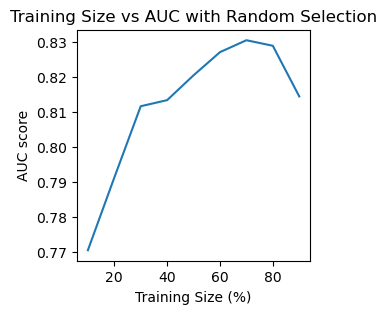

In [31]:
# Random data selection with trainsing size from 1% to 99%
from sklearn.model_selection import train_test_split 
list = np.arange(0.1,1,0.1)
T_s1 = []
AUC_1 = []
for j in list:
    X_train, X_test, y_train, y_test = train_test_split(X_std2, y_c, test_size=j, random_state=42)
    RFC_re = RandomForestClassifier(max_depth = 20, n_estimators = 100,random_state=42)
    RFC_re.fit(X_train,y_train.ravel())
#predict values using the model
    y_hat3 = RFC_re.predict(X_test)
    AUC = roc_auc_score(y_test, y_hat3)    
    T_s1.append((1-j)*100)
    AUC_1.append(AUC)
plt.figure(figsize = (3,3))
plt.plot(T_s1,AUC_1)
plt.title('Training Size vs AUC with Random Selection')
plt.xlabel('Training Size (%)')
plt.ylabel('AUC score')

Text(0, 0.5, 'AUC score')

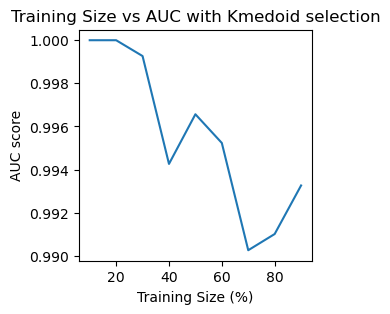

In [32]:
# KMedoids to do data selection with trainsing size from 1% to 99%
from sklearn_extra.cluster import KMedoids
import warnings
warnings.filterwarnings('ignore')
list = np.arange(0.1,1,0.1)
T_s2 = []
AUC_2 = []
for h in list:
    k = int(4916*(1-h))    #4916 is the length of whole dataset
    clusters = KMedoids(n_clusters=k, init = 'random',random_state = 42).fit(X_X)
    L = clusters.labels_
    cluster_centers = clusters.cluster_centers_
    pd_cc = pd.DataFrame(cluster_centers).copy()
    pd_cc = pd_cc.rename(columns={0: "X1", 1: "X2"})
    pd_cc2 = pd_cc.dropna()
    pd_cc3 = pd_cc2.drop_duplicates()
    np_cc = pd_cc3.to_numpy()
    pd_XX3 = pd_XX3.rename(columns={0: "X1", 1: "X2"})
    pd_XX4 = pd_XX3.drop_duplicates()
    result = pd.merge(pd_XX4, pd_cc3, how = 'inner', on = ['X1', 'X2'])
    result2 = result.drop_duplicates()
    result3 = result2.drop_duplicates(['X1','X2'],keep= 'last')
    y_c_km =result3['class'].to_numpy()
    RFC_km = RandomForestClassifier(max_depth = 20, n_estimators = 100,random_state=42)
    RFC_km.fit(np_cc,y_c_km.ravel())
#predict values using the model
    y_hat_km = RFC_km.predict(np_cc)
    AUC = roc_auc_score(y_hat_km,y_c_km)
    T_s2.append((1-h)*100)
    AUC_2.append(AUC)
#print(T_s1)
#print(AUC_1)
plt.figure(figsize = (3,3))
plt.plot(T_s2,AUC_2)
plt.title('Training Size vs AUC with Kmedoid selection')
plt.xlabel('Training Size (%)')
plt.ylabel('AUC score')

### Conclusion
Through the visulization of the dataset, the following conclusion can be made. First, by comparing the result random cross validation, both classification and regression models are not overffitted since each accuracy result is similar to each other. The AUC score of classifier is 0.9993897477624085 and the r2 score of regression is 0.977 on overall dataset training. In regression model training, the 0 bandgap has been dropped to improve the accuracy since most of metal are crowded and effect the regression model accuracy. By looking on the feature importance plot, the most important features are metallic valence and density, which make physical sense to material science since metallic valence is directly related to the bandgap. In the reverse engineering section, average metallic valence, maximum density and average density are been chosen to minimze the features. According to variance ratio for PCA, the number of features can be minimized to 2. The KMedoids attempt to minimize the distance between points labeled to be in a cluster and a point designated as the center of that cluster. In this porject, it is an aquisition policy that can increase the modeling power with minimun number of dataset. The KMedoids are used instead of Kmean is because KMedoids has acutual points from the dataset. By looking at the plot between training size and AUC score. 80% of origin data need to be used to achieve 0.83 howvever it can not reach 0.9 of origin AUC. However, with KMedoids, only 40% of origin data points need be used which could achieve 0.995. However, accoridng to the plot, it can also be found that when the datapoint  is less than 30%, the AUC score almost reach to 1, the guess of that phenoemon is when the data set is less than 30% value, it is overfitting.